In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 435)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,thick_12.0,thick_15.0,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0,0,0,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0,0,0,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0,0,0,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0,0,0,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0,0,0,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
#Volumic cost calculation

dataset['VOL_COST_CONVHULL'] = dataset['VAMAT'] / (dataset['convex_hull_area'] * dataset['thickness'])
dataset['VOL_COST_RECTANGLE'] = dataset['VAMAT'] / (dataset['minimum_rectangle_area'] * dataset['thickness'])
dataset['VOL_COST_MPATTERN'] = dataset['VAMAT'] / (dataset['no_hole_area'] * dataset['thickness'])
dataset['VOL_COST_TOTAREA'] = dataset['VAMAT'] / (dataset['total_area'] * dataset['thickness'])

In [4]:
#dataset.columns.values

In [5]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
Done !


(5401, 436)

In [6]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('bend_gr_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5401, 436)

# cleaning to have at least min occurences

In [7]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
9
20.0 will be dropped


(5358, 436)

# Target definition

In [8]:
target = 'VAMAT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Outlier tracking - VAMAT

In [9]:
toplimit = .90 #We drop the top 10%
botlimit = .02 #we drop the bottom 2%

In [10]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
#dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

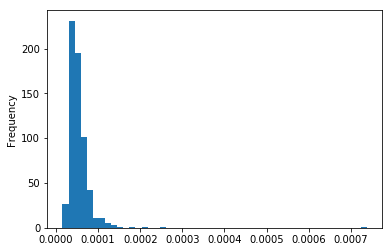

In [11]:
df = dataset[dataset['thickness'] == 5]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [12]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.90            0.000032
3.0       0.02            0.000018
          0.90            0.000049
4.0       0.02            0.000023
          0.90            0.000069
5.0       0.02            0.000028
          0.90            0.000075
6.0       0.02            0.000033
          0.90            0.000102
8.0       0.02            0.000045
          0.90            0.000145
10.0      0.02            0.000063
          0.90            0.000205
12.0      0.02            0.000062
          0.90            0.000211
15.0      0.02            0.000081
          0.90            0.000248

In [13]:
# If vamat is target, cleaning
if target == 'VAMAT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset['SURF_COST_MPATTERN'] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset['SURF_COST_MPATTERN'] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4709, 437)

# Outlier tracking - VALAJOUT

In [14]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [15]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

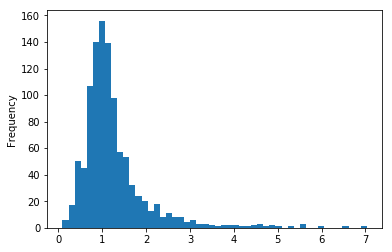

In [16]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [17]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.622900
                     0.95          1.394000
          4          0.02          0.570320
                     0.95          2.148700
          5          0.02          0.225400
                     0.95          2.037333
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.698875
                     0.95          1.446875
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.216800
                     0.95          5.396000
          1          0.02          0.393600
                     0.95          1.480000
          2          0.02          0.403867
                     0.95          1.871000
          3          0.02          0.362500
                     0.95          2.406250
...                                     ...
10.0      0          0.02          0.584200
                     0.95          9.095500
          1          0.02          0.890800
                     0.95          4.214000
          2          0.02          0.510600
                     0.95          3.856167
          3          0.02          0.990650
                     0.95          3.825000
          4          0.02          1.149520
                     0.95          2.973600
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.910000
          1          0.02          0.225200
                     0.95          2.349000
          2          0.02          0.430400
                     0.95          4.100667
          3          0.02          0.621250
                     0.95          1.167625
          4          0.02          1.814120
                     0.95          1.819700
15.0      0          0.02          0.732800
                     0.95          7.974000
          1          0.02          1.100000
                     0.95          2.525000
          2          0.02          0.853333
                     0.95          4.984667
          3          0.02          0.870000
                     0.95          0.870000

[148 rows x 1 columns]

In [18]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset['APPROX_BEND_COST'] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset['APPROX_BEND_COST'] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4709, 438)

## Target review

In [19]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VAMAT
count,4709.000000
mean,5.733179
std,10.198514
min,0.110000
25%,0.860000
50%,2.350000
75%,6.170000
max,125.100000


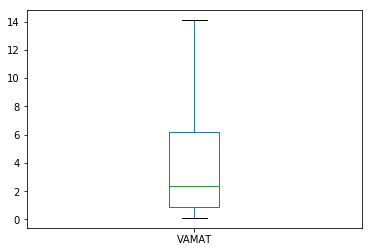

In [20]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [21]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

#Bend as a float
limitedset.append('thickness')

## Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

#Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

#Bends in groups
limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

#bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

print(len(limitedset))
limitedset

153


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count',
 'bend_gr_0_bend_radius_count',
 'bend_gr_0_bend_radius_countdif',
 'bend_gr_0_bend_radius_mean',
 'bend_gr_0_bend_radius_std',
 'bend_gr_0_bend_radius_max',
 'bend_gr_0_bend_radius_min',
 'bend_gr_0_bend_angle_countdif',
 'bend_gr_0_bend_angle_mean',
 'bend_gr_0_bend_angle_std',
 'bend_gr_0_bend_angle_max',
 'bend_gr_0_bend_angle_min',
 'bend_gr_0_bend_direction_countdif',
 'bend_gr_0_bend_direction_mean',
 'bend_gr_0_bend_direction_std',
 'bend_gr_0_bend_direction_max',
 'bend_gr_0_bend_direction_min',
 'bend_gr_0_deformation_length_mean',
 'bend_gr_0_deformation_length_std',
 'bend_gr_0_deformation_length_max',
 'bend_gr_0_deformation_length_min',
 'bend_gr_0_merged_bend_mean',
 'bend_gr_0_merged_bend_std',
 'bend_gr_0_merged_

In [22]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

# Blocs creation

In [23]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [25]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [26]:
#regressions
import lightgbm as lgb

gbm = lgb.LGBMRegressor(objective='regression',
                        learning_rate=0.05,
                        n_estimators=400,
                        max_depth=500,
                        #lambda_l1=0.1,
                        min_child_samples=10,
                        random_state=0,
                       )

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [28]:
pipe = [('scaler', scaler), ('gbm', gbm)]
regpip = Pipeline(pipe)

In [29]:
regpip.fit(X_train[limitedset], y_train[target])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=500, min_child_samples=10,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))])

In [30]:
param_grid = {
    #'gbm__learning_rate': [0.05, 0.1, ],
    #'gbm__n_estimators': [300, 400, 500],
    'gbm__min_child_samples' : [10,5,15],
    #'gbm__lambda_l1': np.logspace(-3,3,4),
    #'gbm__lambda_l2': np.logspace(-3,3,4),
    #'gbm__max_bin':[200, 150],
    #'gbm__num_leaves':[20,25],
    #'gbm__max_depth':[None, 500,750],
    #'gbm__min_split_gain':[0,.1]
    }

#MSE version
gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=5)

#MAPE version
#gridgbm = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=2)

In [31]:
gridgbm.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] gbm__min_child_samples=10 .......................................
[CV] gbm__min_child_samples=10 .......................................
[CV] gbm__min_child_samples=10 .......................................
[CV]  gbm__min_child_samples=10, score=-8.38588168426161, total=   3.5s
[CV] gbm__min_child_samples=5 ........................................
[CV]  gbm__min_child_samples=10, score=-3.730259933414009, total=   5.5s
[CV] gbm__min_child_samples=5 ........................................
[CV]  gbm__min_child_samples=10, score=-9.111446220437271, total=   7.2s
[CV] gbm__min_child_samples=5 ........................................
[CV]  gbm__min_child_samples=5, score=-9.99729974080435, total=   5.1s
[CV] gbm__min_child_samples=15 .......................................
[CV]  gbm__min_child_samples=5, score=-9.046743275469723, total=   6.8s
[CV] gbm__min_child_samples=15 .......................................
[CV]  gbm__m

[Parallel(n_jobs=-2)]: Done   6 out of   9 | elapsed:   13.2s remaining:    6.6s


[CV]  gbm__min_child_samples=15, score=-8.789262266036006, total=   4.8s
[CV]  gbm__min_child_samples=15, score=-4.069680459614321, total=   3.6s
[CV]  gbm__min_child_samples=15, score=-10.531330616853163, total=   4.0s


[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:   17.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbm', LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=500, min_child_samples=10,
       min_child_weight=0.001, min_sp...0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'gbm__min_child_samples': [10, 5, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=5)

In [32]:
target

'VAMAT'

In [33]:
gridgbm.best_params_

{'gbm__min_child_samples': 10}

In [34]:
gridgbm.best_score_

-7.076877662060879

In [35]:
mean_absolute_percentage_error(y_test[target], gridgbm.predict(X_test[limitedset]))

11.151456248226017

In [36]:
mean_squared_error(y_test[target], gridgbm.predict(X_test[limitedset]))

5.442125156193151

In [37]:
mean_squared_error(y_train[target], gridgbm.predict(X_train[limitedset]))

0.16915112734484386

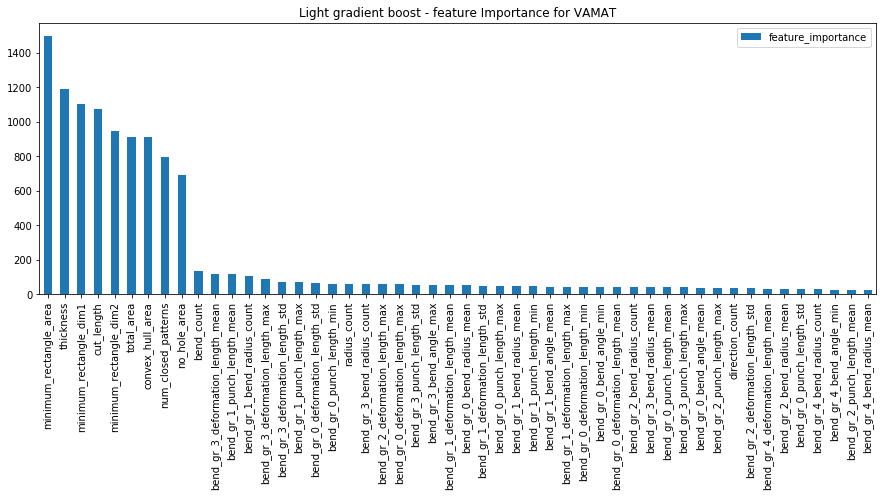

In [38]:
featimp = list(gridgbm.best_estimator_.named_steps['gbm'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# Solution comparison

In [39]:
prediction_lgbm = gridgbm.predict(X_test[limitedset])

In [40]:
resultset = pd.DataFrame({'target': y_test[target],
                          'pred_lgbm':prediction_lgbm,
                            }, index=y_test.index)
resultset.head()

,pred_lgbm,target
COART,,
L7011061,12.472791,13.41
L7048930,0.815867,0.80
L1801770,2.977975,2.87
L6006020,1.333596,1.30
L8817230,1.048921,1.00


In [41]:
mean_squared_error(resultset['target'], resultset['pred_lgbm'])

5.442125156193151

In [42]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_lgbm'])

11.151456248226017

In [43]:
resultset['MSE_lgbm'] = (resultset['target']-resultset['pred_lgbm'])**2
resultset.head()

,pred_lgbm,target,MSE_lgbm
COART,,,
L7011061,12.472791,13.41,0.878360
L7048930,0.815867,0.80,0.000252
L1801770,2.977975,2.87,0.011659
L6006020,1.333596,1.30,0.001129
L8817230,1.048921,1.00,0.002393


In [44]:
resultset['MSE_lgbm'].mean()

5.442125156193145

In [45]:
#
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_lgbm,target,MSE_lgbm,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,...,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,VOL_COST_TOTAREA,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L7011061,12.472791,13.41,0.878360,11328.504883,33,0,880123.875000,908674.500000,2621.000000,...,13.41,21.79,35.20,0.000007,0.000007,0.000007,6+,0.000008,0.000015,2.421111
1,L7048930,0.815867,0.80,0.000252,455.384277,1,0,10492.765625,14450.000000,170.000000,...,0.80,1.01,1.81,0.000009,0.000007,0.000010,0,0.000010,0.000076,1.010000
2,L1801770,2.977975,2.87,0.011659,1284.946045,1,0,39064.164062,39064.164062,574.473022,...,2.87,2.06,4.93,0.000007,0.000007,0.000007,1-2,0.000007,0.000073,0.686667
3,L6006020,1.333596,1.30,0.001129,1163.171875,1,0,49065.355469,50891.234375,292.260010,...,1.30,2.20,3.50,0.000006,0.000006,0.000007,3-5,0.000007,0.000026,0.440000
4,L8817230,1.048921,1.00,0.002393,653.218689,6,0,13901.731445,14641.000000,121.000000,...,1.00,1.56,2.56,0.000007,0.000007,0.000007,0,0.000007,0.000069,1.560000


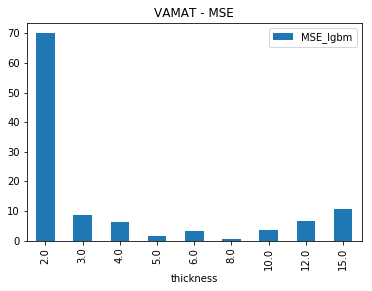

,MSE_lgbm
thickness,
2.0,69.943776
3.0,8.657746
4.0,6.251730
5.0,1.536211
6.0,3.166278
8.0,0.593097
10.0,3.571358
12.0,6.655824
15.0,10.560556


In [46]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_lgbm', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
df

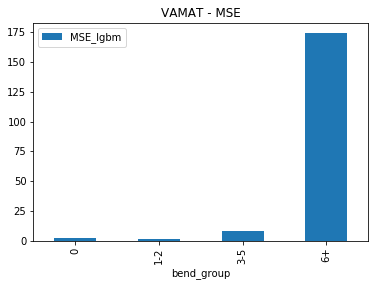

,MSE_lgbm
bend_group,
0,2.238568
1-2,1.637990
3-5,7.593807
6+,174.088933


In [47]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_lgbm', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
df

In [48]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_lgbm']), axis=1)
comparisonset['percent_error'] = ((comparisonset['target'] / comparisonset['pred_lgbm'])-1)*100
comparisonset[['target', 'pred_lgbm', 'MAPE_error']].head()

,target,pred_lgbm,MAPE_error
0,13.41,12.472791,6.988879
1,0.80,0.815867,1.983319
2,2.87,2.977975,3.762187
3,1.30,1.333596,2.584280
4,1.00,1.048921,4.892119


In [49]:
#MAPE
comparisonset['MAPE_error'].mean()

11.151456248226035

In [50]:
#If bends use this line
if target == 'VALAJOUT':
    df = comparisonset[['MSE_lgbm', 'MAPE_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_lgbm', 'MAPE_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_lgbm': ['mean', 'max'], 'MAPE_error': ['mean', 'max'],'COART':['count'] })

MSE_lgbm              MAPE_error             COART
                mean          max       mean         max count
thickness                                                     
2.0        69.943776  1339.874832  35.198993  204.951292    31
3.0         8.657746   453.402454  10.540294   58.854232   125
4.0         6.251730   566.277793  11.185333   74.428464   165
5.0         1.536211   147.416632   9.730387   45.109504   155
6.0         3.166278   441.701593  10.470732   71.287879   321
8.0         0.593097    30.662287   8.219485  110.747076   266
10.0        3.571358   131.383654   9.954659   89.795674   183
12.0        6.655824   129.926984  15.962948   99.960661   108
15.0       10.560556   470.836683  15.276663   53.364991    59

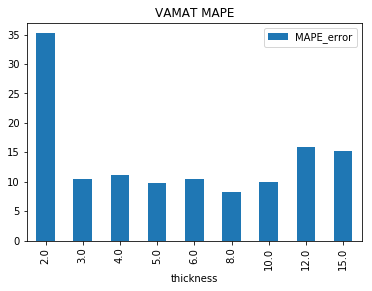

,MAPE_error
thickness,
2.0,35.198993
3.0,10.540294
4.0,11.185333
5.0,9.730387
6.0,10.470732
8.0,8.219485
10.0,9.954659
12.0,15.962948
15.0,15.276663


In [51]:
df = comparisonset[['MAPE_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
df

In [52]:
df = comparisonset[['COART', 'thickness']]
df.groupby('thickness').count()

,COART
thickness,
2.0,31
3.0,125
4.0,165
5.0,155
6.0,321
8.0,266
10.0,183
12.0,108
15.0,59


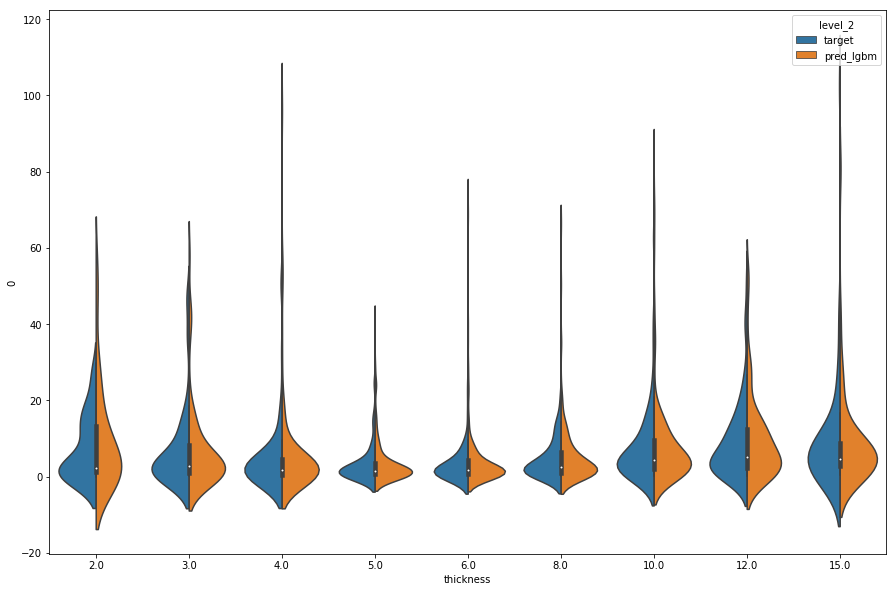

In [53]:
#Violin plot
df=comparisonset[['target', 'pred_lgbm', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)

plt.show()

In [54]:
df = comparisonset[['MSE_lgbm', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_lgbm'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L7067210    1339.874832
           L7070650     749.273316
           L3124070      22.866433
           L7012211      15.270681
           L6020240      14.638975
3.0        L3122460     453.402454
           L3122380     449.751705
           L1608760      22.902067
           L8416630      22.732485
           L8416760      22.732485
4.0        L8038520     566.277793
           L8047430     130.961294
           L6010030      86.153413
           L6703240      62.021353
           L3126650      47.716931
5.0        L3122540     147.416632
           L8833680      35.633457
           L8819680      17.649991
           L7018041      10.389992
           L6010920       4.960147
6.0        L8059260     441.701593
           L3052760     230.728728
           L3020640      76.037276
           L6000541      61.307573
           L7069750      43.181313
8.0        L8049000      30.662287
           L8835060      23.544321
           L7052740      23.502098


In [55]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 8]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 10000]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,800,863,1244,1248
COART,L2509970,L8835060,L6014840,L2603290
pred_lgbm,3.04682,19.0622,7.69766,1.57361
target,2.6,14.21,8.01,1.6
MSE_lgbm,0.19965,23.5443,0.0975551,0.000696558
cut_length,1323.45,3616.89,1797.27,812.511
num_closed_patterns,4,5,3,3
num_open_patterns,0,0,0,0
total_area,43451.9,147851,89761.7,16131
minimum_rectangle_area,53812.3,268983,128709,31559.5
minimum_rectangle_dim1,489.203,685.467,495.035,233.774


In [56]:
dataset.loc[['L8835850']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

KeyError: "None of [['L8835850']] are in the [index]"